In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

/var/folders/81/_1yshp9s2sxb1nghxqpzk7b40000gn/T/ipykernel_1852/3377578104.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

display(df_train.sample(5)) # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
18833,1.00,/uberlandia minas gerais/Brazil,AS,NaN,22284,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGESP,3 months ~ 6 months,0,0,NaN,NaN,NaN,NaN,97,False
30531,1.00,//,ID,0.074949,12418,NaN,Enterprise,NaN,1.0,NaN,...,LGECB,3 months ~ 6 months,0,0,0.003079,0.064566,corporate / office,NaN,212,False
59206,1.00,/DF/Brasília/Brazil,AS,0.040000,10232,NaN,Enterprise,NaN,NaN,NaN,...,LGESP,6 months ~ 9 months,0,0,0.000026,0.028777,public facility,NaN,23,False
56677,0.75,/santiago/Chile,ID,0.073248,11760,NaN,SMB,NaN,NaN,NaN,...,LGECL,less than 3 months,0,1,0.001183,0.049840,retail,NaN,283,False
37222,0.50,//Philippines,AS,NaN,33776,NaN,Enterprise,NaN,NaN,NaN,...,LGEPH,NaN,0,0,NaN,NaN,NaN,NaN,0,False


In [4]:
"""
*/*/country -> country
"""

def column_short(df : pd.DataFrame, column : str):
    short_column = column+'_short'
    df[short_column] = "others"
    df[short_column][df[column].notna()] = df.copy()[df[column].notna()][column].apply(lambda x : x.split('/')[-1].split(',')[-1].strip().lower())
    df[short_column].replace("", "others", inplace=True)
    # write aaa@aa.com -> others regex : r'@.*'
    df[short_column].replace(to_replace=r'^[a-zA-Z0-9][a-zA-Z0-9._]+[@][a-zA-Z][A-Za-z.]+[.]\w{2,}', value="others", inplace=True, regex=True)


def column_replace(df : pd.DataFrame, column : str, replace_dict : dict):
    df[column].replace(r"*[]", inplace=True, regex=True)

In [60]:
def target_ratio(column : str, nums : int):
    targets_dict = df_train[df_train[column] == nums]['is_converted'].value_counts(ascending=False).to_dict()
    if len(targets_dict) == 0:
        F_target, T_target = 0, 0

    elif len(targets_dict) == 1:
        if True in targets_dict.keys():
            F_target = 0
            T_target = targets_dict[True]
        elif False in targets_dict.keys():
            T_target = 0
            F_target = targets_dict[False]
    
    else:
        F_target = targets_dict[False]
        T_target = targets_dict[True]

    if F_target == 0 and T_target==0:
        print("{0} value of {1}".format(nums, column)+"'s target ratio : {0} / {1}, None".format(T_target, F_target), "\n")   
    elif F_target == 0:
        print("{0} value of {1}".format(nums, column)+"'s target ratio : {0} / {1}, only True".format(T_target, F_target), "\n")
    else:
        print("{0} value of {1}".format(nums, column)+"'s target ratio : {0} / {1} = {2:.2f} %".format(T_target, F_target, T_target / F_target * 100), "\n")

### Column : bant_submit

In [56]:
"""
0, 0.25, 0.5, 0.75, 1 의 class가 존재

class 별로 target 비율에 대해서 고려하기

1 : 9.23%
0.75 : 10.57%
0.5 : 5.76%
0.25 : 10.98%
0 : 19.03%

0일때, 0.5일때 꽤 유의미한 차이가 있고, 1, 0.75, 0.25는 비슷한 비율을 가지고 있다.
"""
columns = 'bant_submit'
for nums in df_train[columns].unique():
    target_ratio(columns, nums)

1.0 value of bant_submit's target ratio : 1442 / 15619 = 9.23 % 

0.75 value of bant_submit's target ratio : 1117 / 10564 = 10.57 % 

0.5 value of bant_submit's target ratio : 937 / 16255 = 5.76 % 

0.25 value of bant_submit's target ratio : 1272 / 11580 = 10.98 % 

0.0 value of bant_submit's target ratio : 82 / 431 = 19.03 % 



### Column : customer_country

In [7]:
def show_customer_country_from_short(country_short : str):
    print(df_train[df_train['customer_country_short'] == country_short].customer_country.value_counts())

### Column : business_unit

In [8]:
columns = 'business_unit'
for nums in df_train[columns].unique():
    target_ratio(columns, nums)

AS value of business_unit's target ratio : 1383 / 23391 = 5.91 % 

ID value of business_unit's target ratio : 2620 / 22943 = 11.42 % 

IT value of business_unit's target ratio : 844 / 7820 = 10.79 % 

Solution value of business_unit's target ratio : 3 / 293 = 1.02 % 

CM value of business_unit's target ratio : 0 / 2 = 0.00 % 



### Column : com_reg_ver_win_rate

In [55]:
columns = 'com_reg_ver_win_rate'
temp_dict = df_train[columns].value_counts().to_dict()
temp_dict = {k: v for k, v in sorted(temp_dict.items(), key=lambda x : x[0], reverse=True)}

for k, v in temp_dict.items():
    target_ratio(columns, k)

1.0 value of com_reg_ver_win_rate's target ratio : 4 / 6 = 66.67 % 

0.8333333333333334 value of com_reg_ver_win_rate's target ratio : 7 / 10 = 70.00 % 

0.6428571428571429 value of com_reg_ver_win_rate's target ratio : 321 / 461 = 69.63 % 

0.6153846153846154 value of com_reg_ver_win_rate's target ratio : 8 / 16 = 50.00 % 

0.5 value of com_reg_ver_win_rate's target ratio : 28 / 6 = 466.67 % 

0.4615384615384615 value of com_reg_ver_win_rate's target ratio : 8 / 8 = 100.00 % 

0.4444444444444444 value of com_reg_ver_win_rate's target ratio : 4 / 8 = 50.00 % 

0.4 value of com_reg_ver_win_rate's target ratio : 6 / 6 = 100.00 % 

0.3902439024390244 value of com_reg_ver_win_rate's target ratio : 28 / 67 = 41.79 % 

0.3636363636363636 value of com_reg_ver_win_rate's target ratio : 4 / 9 = 44.44 % 

0.3333333333333333 value of com_reg_ver_win_rate's target ratio : 32 / 78 = 41.03 % 

0.2692307692307692 value of com_reg_ver_win_rate's target ratio : 8 / 36 = 22.22 % 

0.25 value of com_reg_

### Column : customer_idx

In [10]:
columns = 'customer_idx'
df_train[columns].value_counts()

customer_idx
47466    7686
25096    2421
37680     367
18030     331
21321     162
         ... 
39487       1
41241       1
39422       1
22515       1
30268       1
Name: count, Length: 35112, dtype: int64

In [20]:
columns = 'customer_idx'
# value_counts 결과 dict로 변환
temp_dict = df_train[columns].value_counts().to_dict()
temp_dict = {k: v for k, v in sorted(temp_dict.items(), key=lambda x:-x[1])}


for_plot = []
def temp_target_ratio(
        column : str, 
        nums : int, 
        value : int):
    
    targets_dict = df_train[df_train[column] == nums]['is_converted'].value_counts(ascending=False).to_dict()

    if len(targets_dict) == 1:
        if True in targets_dict.keys():
            T_target = targets_dict[True]
        elif False in targets_dict.keys():
            T_target = 0
    else:
        T_target = targets_dict[True]
    
    trigger = round(T_target / value * 100, 2)

    # portion value of target for histplot
    for_plot.append(trigger)
    
    # if portion 80%, add to set (standards for other columns)
    if trigger >= 80:
        holigun.add(nums)

holigun = set()
for k, v in temp_dict.items():
    temp_target_ratio(columns, k, v)

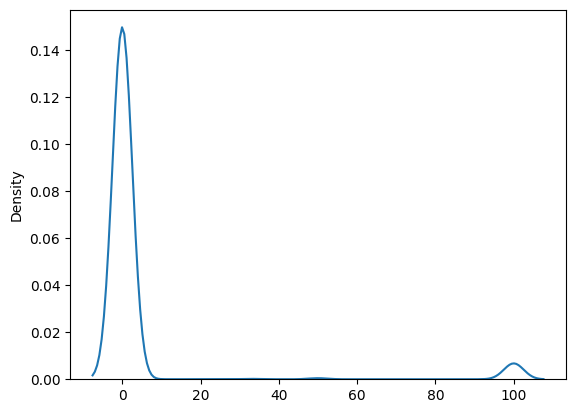

충성고객 회사 개수 : 1515
충성고객 회사명단 : {10, 40986, 24608, 24610, 16433, 8251, 16443, 41021, 8256, 16451, 41032, 16458, 32846, 24659, 8282, 96, 16481, 98, 16480, 8297, 41067, 8307, 32889, 41082, 32897, 8334, 8335, 32912, 41112, 41113, 16541, 24737, 32934, 32938, 41135, 24761, 16573, 16574, 32961, 32966, 8391, 41163, 8407, 8409, 226, 24813, 240, 241, 242, 33010, 24820, 24819, 33016, 255, 33029, 24839, 24840, 41227, 8460, 41233, 33053, 8478, 33058, 24873, 24883, 8509, 24905, 33100, 16721, 16727, 348, 41314, 8555, 33152, 8582, 391, 8583, 8585, 8586, 16781, 33167, 33168, 41359, 8599, 8602, 8603, 33196, 8624, 16819, 8630, 8632, 442, 443, 444, 447, 41412, 41414, 455, 456, 457, 458, 459, 460, 461, 462, 25039, 463, 465, 466, 464, 16856, 8672, 483, 8676, 8681, 16873, 8683, 25073, 41457, 498, 25076, 33269, 25084, 8704, 8705, 16898, 25096, 25097, 41485, 33296, 41489, 529, 33299, 33300, 25117, 550, 555, 570, 41537, 41538, 8781, 33375, 25192, 41576, 33399, 33407, 17023, 25217, 8840, 8841, 8842, 8843, 665, 41

In [48]:
# plot portions
sns.kdeplot(for_plot)
plt.show()

# print result of portion
print('충성고객 회사 개수 :', len(holigun))
print('충성고객 회사명단 :', holigun, '\n')

# numbers of over_80% and below_80%
above_80 = 0
below_80 = 0
for k, v in Counter(for_plot).items() :
    if k >= 80:
        above_80 += v
    else:
        below_80 += v

print("80% 이상 :", above_80, "개")
print("80% 미만 :", below_80, "개")
    

### Column : customer_type

In [61]:
# 43961 is null, delete column
print(df_train['customer_type'].isnull().sum())

column = 'customer_type'
for nums in df_train[column].unique():
    target_ratio(column, nums)


43961
End-Customer value of customer_type's target ratio : 757 / 5890 = 12.85 % 

Specifier/ Influencer value of customer_type's target ratio : 189 / 2336 = 8.09 % 

Service Partner value of customer_type's target ratio : 49 / 300 = 16.33 % 

Channel Partner value of customer_type's target ratio : 166 / 1202 = 13.81 % 

nan value of customer_type's target ratio : 0 / 0, None 

Corporate value of customer_type's target ratio : 0 / 31 = 0.00 % 

End Customer value of customer_type's target ratio : 711 / 3285 = 21.64 % 

Specifier / Influencer value of customer_type's target ratio : 15 / 28 = 53.57 % 

Solution Eco-Partner value of customer_type's target ratio : 43 / 103 = 41.75 % 

Distributor value of customer_type's target ratio : 0 / 4 = 0.00 % 

Other value of customer_type's target ratio : 0 / 10 = 0.00 % 

System Integrator value of customer_type's target ratio : 0 / 2 = 0.00 % 

Consultant value of customer_type's target ratio : 11 / 4 = 275.00 % 

Installer value of customer_type

### Column : Enterprise

In [62]:
column = 'enterprise'
for nums in df_train[column].unique():
    target_ratio(column, nums)


Enterprise value of enterprise's target ratio : 2114 / 35669 = 5.93 % 

SMB value of enterprise's target ratio : 2736 / 18780 = 14.57 % 



### Column : historical_existing_cnt

In [65]:
column = 'historical_existing_cnt'

print(df_train[column].value_counts(), "\n" )

for nums in df_train[column].unique():
    target_ratio(column, nums)

historical_existing_cnt
4.0       2957
0.0       1973
1.0       1967
19.0      1441
16.0      1132
          ... 
404.0        1
145.0        1
1394.0       1
199.0        1
108.0        1
Name: count, Length: 136, dtype: int64 

nan value of historical_existing_cnt's target ratio : 0 / 0, None 

12.0 value of historical_existing_cnt's target ratio : 4 / 44 = 9.09 % 

144.0 value of historical_existing_cnt's target ratio : 2 / 1 = 200.00 % 

3.0 value of historical_existing_cnt's target ratio : 23 / 672 = 3.42 % 

23.0 value of historical_existing_cnt's target ratio : 3 / 16 = 18.75 % 

47.0 value of historical_existing_cnt's target ratio : 2 / 9 = 22.22 % 

0.0 value of historical_existing_cnt's target ratio : 305 / 1668 = 18.29 % 

1.0 value of historical_existing_cnt's target ratio : 86 / 1881 = 4.57 % 

19.0 value of historical_existing_cnt's target ratio : 24 / 1417 = 1.69 % 

42.0 value of historical_existing_cnt's target ratio : 2 / 9 = 22.22 % 

75.0 value of historical_existin

### Column : id_strategic_ver

In [66]:
# only 1 value others are null
# impute null to 0

df_train['id_strategic_ver'].value_counts()
# df_train['id_strategic_ver'].fillna(0, inplace=True)

id_strategic_ver
1.0    3444
Name: count, dtype: int64

### Column : it_strategic_ver

In [ ]:
# only 1 value others are null
# impute null to 0

df_train['it_strategic_ver'].value_counts()
# df_train['it_strategic_ver'].fillna(0, inplace=True)

### Column : idit_strategic_ver

In [ ]:
# only 1 value others are null
# impute null to 0

df_train['idit_strategic_ver'].value_counts()
# df_train['idit_strategic_ver'].fillna(0, inplace=True)

### Column : customer_job

### Column : lead_desc_length

### Column : inquiry_type

### Column : product_category

### Column : product_subcategory

### Column : product_modelname

### Column : customer_country.1

### Column : customer_position

### Column : reponse_corporate

### Column : expected_timeline

### Column : vers_cus

### Column : vers_pro

### Column : ver_win_rate_x

### Column : ver_win_ratio_per_bu

### Column : business_area

### Column : business_subarea

### Column : lead_owner

### Column : is_converted